<a href="https://colab.research.google.com/github/minhquyminhquy/PINNs/blob/main/Quy_Le_Physics_Informed_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reproducing Growth Model Results with Physics-Informed Neural Networks (PINNs)

By Quy Le, Sep-Oct 2024

Email: quy.le@tuni.fi

In this notebook, I will implement a Python version of the growth model in the following [paper](https://doi.org/10.3390/ai5030074) , using PyTorch, to simulate the dynamics of damped harmonic oscillation.

To my understanding, Physics-Informed Neural Networks (PINNs) is powerful in solving differential equations because of the integration of physical knowledge directly into the neural network's loss function. This makes the model both utilized the data-driven and physic-based losses, allowing the model respect the physical constraints.

In this first section of the notebook, I applied PINNs to predict a very simple ODEs, which helped me gained the intuition about differential equations and PINNs. In the second session, I applied PINNs to the Damped Harmonic Equation, and compare the result with PINNs model and traditional neural network model, which uses only a data-driven loss function.

The paper: Farea, A., Yli-Harja, O., & Emmert-Streib, F. (2024). Understanding Physics-Informed Neural Networks: Techniques, applications, trends, and challenges. *AI*, 5(3), 1534-1557. https://doi.org/10.3390/ai5030074

# I. Applying PINNs to a simple ODE

## 1. Import Libraries and Neural Network Architecture Selection

### 1.1 Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

### 1.2 Neural Network Architecture Selection
Here, I create a fully contected Artificial Neural Networks (ANNs). Hopefully, I will implement an ANNs from Scratch in this week and apply to this notebook.

 Architecture:

* 3 Layers: Input -> Hidden -> Output

* Hidden layer: 20 neurons

* Activation function: ReLU

In [ ]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        #self.input_layer = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        #self.hidden_layers = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN),activation()]) for _ in range(N_LAYERS-1)])
        #self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.input_layer = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.hidden_layers = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self,x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x



## 2. Define the Growth Model Equation

Here, I examined a simple differential equation:

$$
\frac{dy}{dx}+y=sin(x) \tag{1}
$$

**Initial condition:** $ y(0) = 0 $

**Exact solution:** $ y(x) = e^{-x}(sin(x)-cos(x))+cos(x) $



In [ ]:
def exact_solution_I(x: torch.Tensor) -> torch.Tensor:
    """
    Define the solution for the differential equation (1)

    Parameters:
    x: input value ((torch tensor)

    Return:
    y: output value (torch tensor)
    """
    y = torch.exp(-x) * (torch.sin(x) - torch.cos(x)) + torch.cos(x)
    return y

## 3. Define loss function
The loss function in the PINNs approach combines data-driven loss (the error between the predicted output and actual training data) and physics-based loss (the residual of the differential equation).

In [ ]:
def loss_pinn_I(model, x: torch.Tensor) -> torch.Tensor:
    """
    Compute the combined loss for the PINNs apply to (1).

    Parameters:
    - model: defined Neural network model
    - x: input tensor (torch tensor)

    Return:
    - total_loss: combine data-driven and physics-based loss (torch tensor)
    """
    assert x.ndim == 2, "Input tensor x should be 2D"

    # Loss based on the Neural Network's Residual
    y_actual = exact_solution_I(x)
    y_pred = model(x)
    data_loss = torch.mean((y_pred - y_actual)**2)

    # Loss based on the Differential Equation's Residual
    x.requires_grad_(True)
    with torch.set_grad_enabled(True): # Compute the derivatives
        y_pred = model(x)
        dy_dx = torch.autograd.grad(y_pred, x, torch.ones_like(y_pred), create_graph=True)[0]

    physics_loss = torch.mean((dy_dx + y_pred - torch.sin(x))**2)

    # Total loss
    total_loss =  physics_loss
    return total_loss

## 3. Neural Network Implementation
Architecture:
- 3 Layers: Input -> Hidden -> Output
- Hidden layer: 20 neurons
- Activation function: Tanh

In [ ]:
model_I = FCN(1,1,64,6)

## 4. Training the Neural Network
Train the model using both data-driven loss and physic-based loss for every epoch. For every 5000 epochs, plot the model's output compared to the exact solution.

* My training samples:

x_train = range(1, 81)

y_train = exact_solution(x_train)

x_test = range(81, 101)

y_test = exact_solution(x_test)

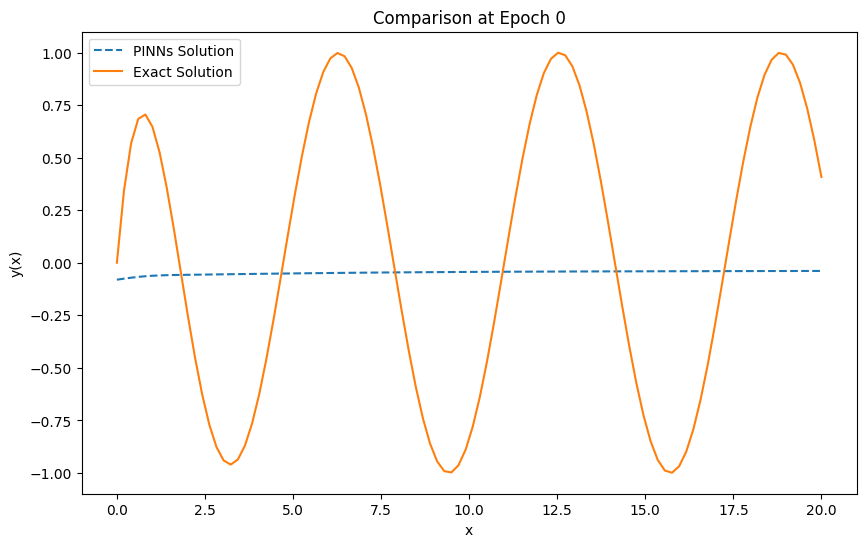

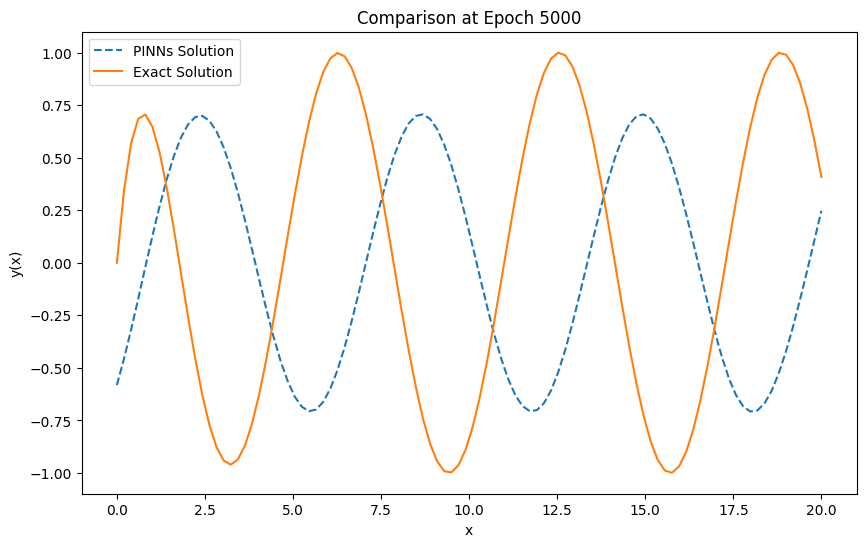

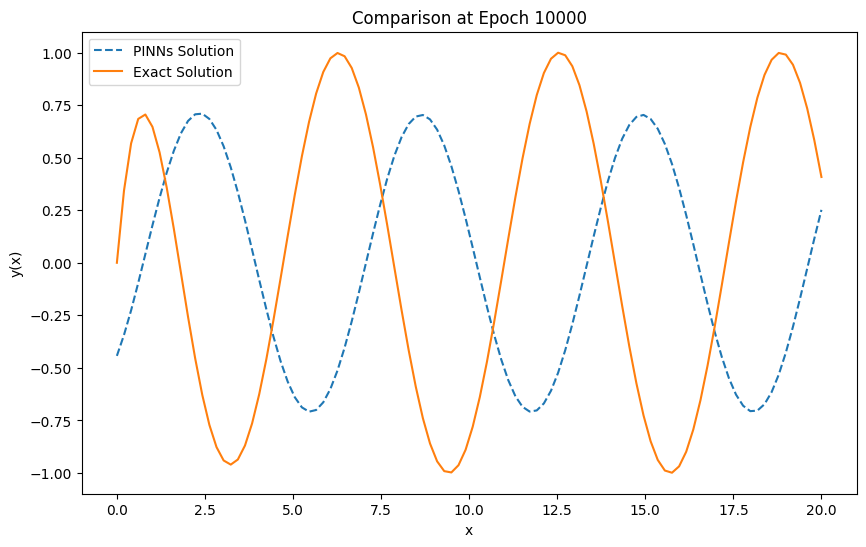

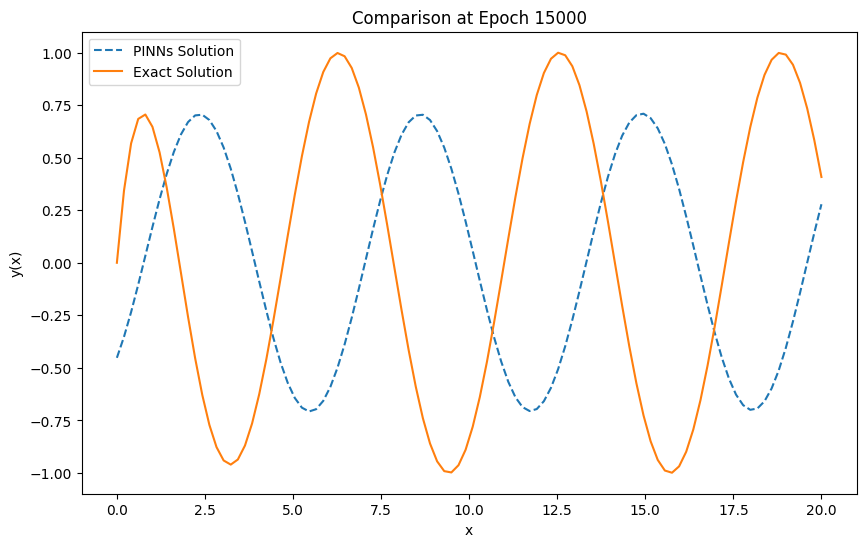

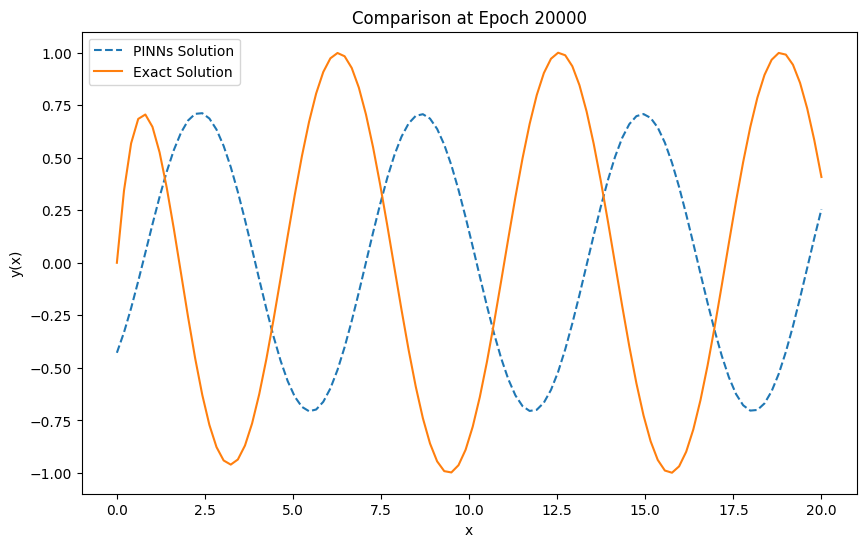

In [ ]:
optimizer = torch.optim.Adam(model_I.parameters(), lr=0.001)
x_train = torch.linspace(0, 20, 100, requires_grad=True).view(-1, 1)

epochs = 20001
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_pinn_I(model_I, x_train)
    loss.backward()
    optimizer.step()

    # Plot every 5000 epochs
    if epoch % 5000 == 0:
        with torch.no_grad():
            y_pinn = model_I(x_train)
            y_train = exact_solution_I(x_train)

        #Plot the results
        plt.figure(figsize=(10, 6))
        plt.plot(x_train.detach().numpy(), y_pinn.detach().numpy(), label='PINNs Solution', linestyle='dashed')
        plt.plot(x_train.detach().numpy(), y_train.detach().numpy(), label='Exact Solution', linestyle='solid')
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('y(x)')
        plt.title(f'Comparison at Epoch {epoch}')
        plt.show()

## 5. Model Evaluation and Comparision

### Traditional Neural Network

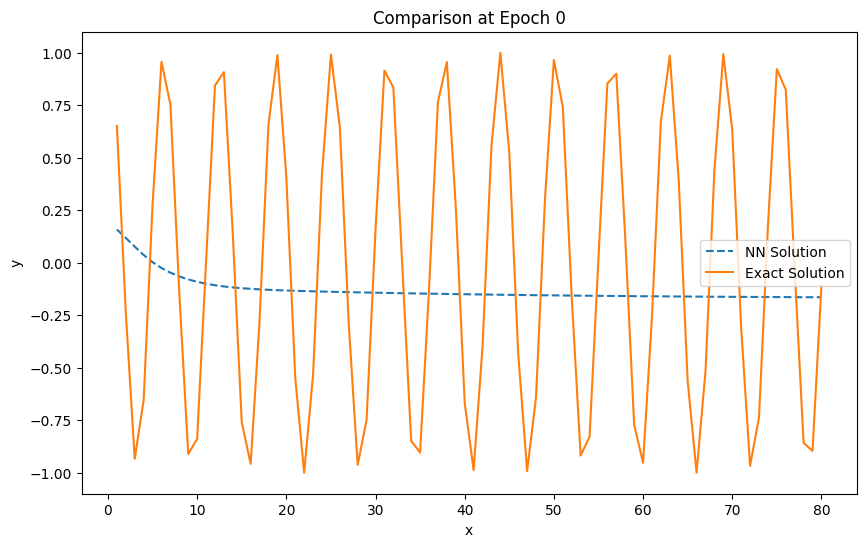

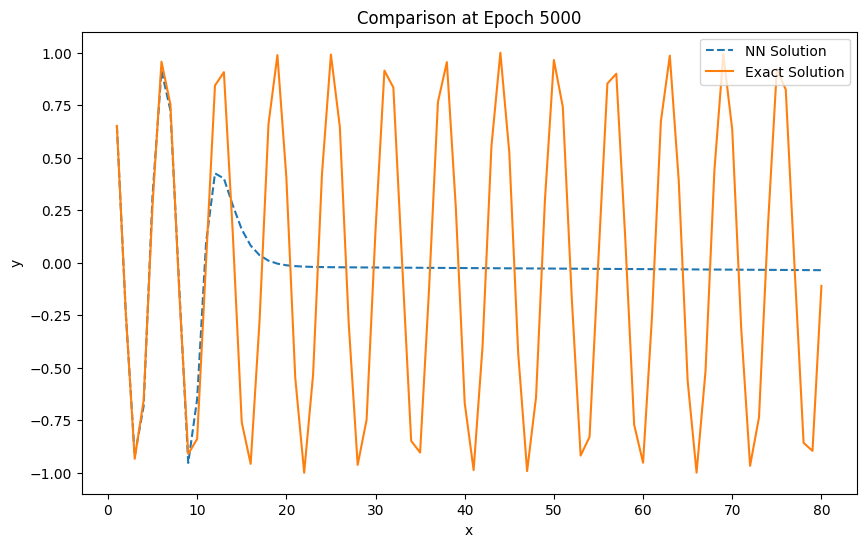

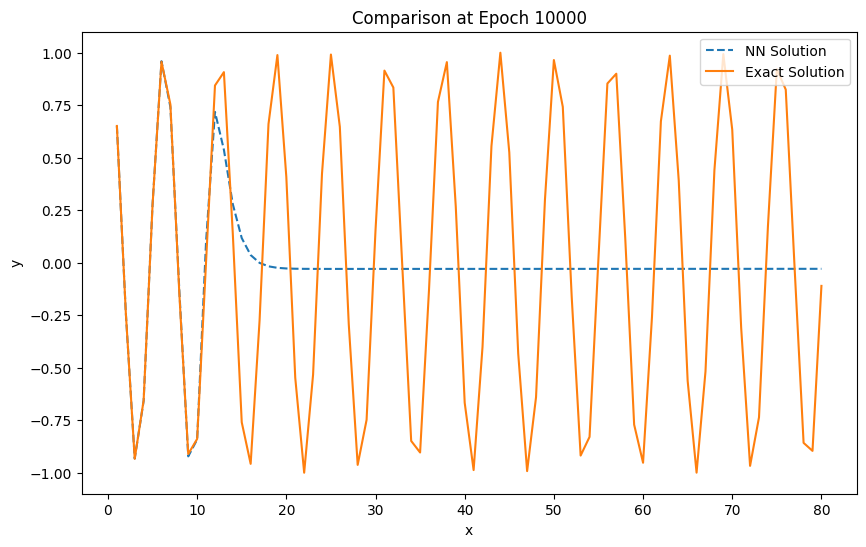

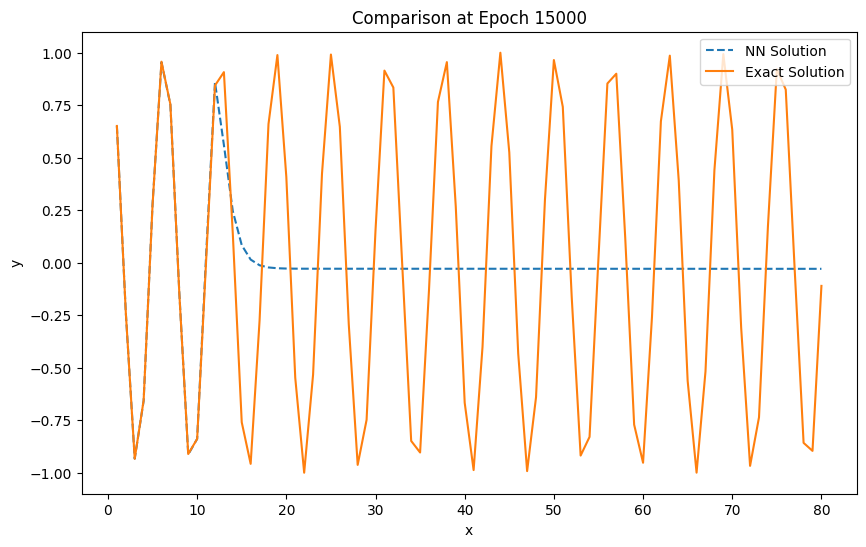

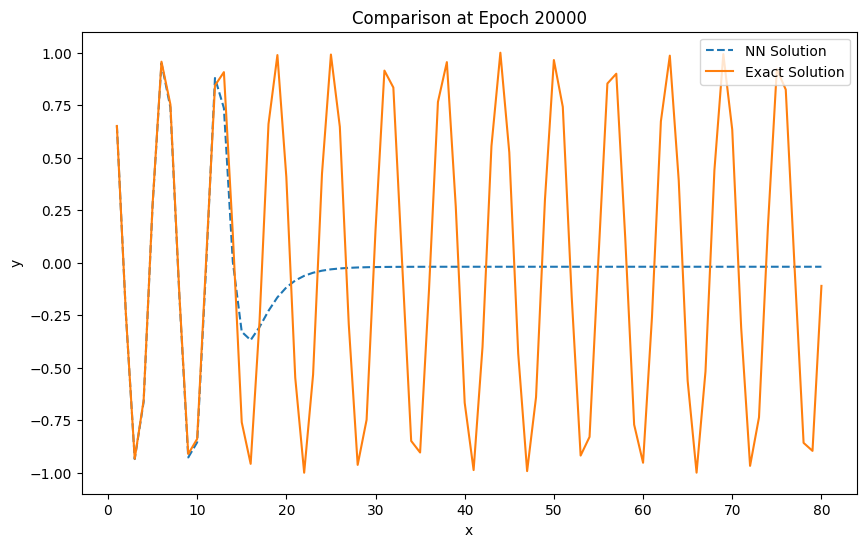

In [ ]:
# Training parameters
simpleNN_model = simpleNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(simpleNN_model.parameters(), lr=0.001)

for epoch in range(epochs):
    simpleNN_model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred = simpleNN_model(x_train)

    # Compute loss
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 5000 == 0:
        # Plotting the NN solution vs. exact solution
        with torch.no_grad():
            y_NN = simpleNN_model(x_train)
            y_exact = exact_solution_I(x_train)

        plt.figure(figsize=(10, 6))
        plt.plot(x_train.detach().numpy(), y_NN.detach().numpy(), label='NN Solution', linestyle='dashed')
        plt.plot(x_train.detach().numpy(), y_exact.detach().numpy(), label='Exact Solution', linestyle='solid')
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'Comparison at Epoch {epoch}')
        plt.show()

### Calculate MSE

In [ ]:
from sklearn.metrics import mean_squared_error

with torch.no_grad():
    x_test = torch.linspace(81, 100, 20).view(-1, 1)
    y_test = exact_solution_I(x_test)
    # PINN model
    y_pinn = model_I(x_test)
    mse_pinn = mean_squared_error(y_test.detach().numpy(), y_pinn.detach().numpy())

    # Traditional NN model
    y_nn = simpleNN_model(x_test)
    mse_nn = mean_squared_error(y_test.detach().numpy(), y_nn.detach().numpy())
    print(f'Mean Squared Error (Traditional NN Model): {mse_nn:.4f}')
    print(f'Mean Squared Error (PINN Model): {mse_pinn:.4f}')

Mean Squared Error (Traditional NN Model): 0.5117
Mean Squared Error (PINN Model): 0.5166


##Analysis and Conclusion
Here, the MSE of the PINNs model is a bit higher than that of the normal NN model. However, it seems that the normal NN model capture the data better than PINNs model.

I suppose the reason the reason that my PINNs model here is not capture the data is because of my loss function.

# II. Applying PINNs to Damped Harmonic Motion

## State the Underdamped Harmonic Oscillator equation
Underdamped Harmonic Oscillator equation:

$x(t) = Ae^{\frac{-bt}{2m}} \cos(w't) $

Where:  
- \( b \): damping coefficient  
- \( k \): spring constant  
- \( A \): amplitude  
- \( m \): mass of object  
- \( w'\): damped angular velocity: $w' = \sqrt{\frac{k}{m}-(\frac{b}{2m})^2}$



In [ ]:
"""
def exact_solution_II(b: float, w0: float, m: float, t: torch.Tensor) -> torch.Tensor:

    Define the solution for underdamped harmonic oscillator.

    Parameters:
    b: damping coefficient (float)
    w0: natural frequency (float)
    m: mass (float)
    t: time points (torch tensor)

    Return:
    x: displacement from equilibrium at each time point (torch tensor)

    # Convert parameters to tensors
    b_tensor = torch.tensor(b, dtype=t.dtype, device=t.device)
    w0_tensor = torch.tensor(w0, dtype=t.dtype, device=t.device)
    m_tensor = torch.tensor(m, dtype=t.dtype, device=t.device)

    # Calculate w_prime and other terms of the equation
    w_prime = torch.sqrt(w0_tensor**2 - (b_tensor / (2 * m_tensor))**2)
    A = 1
    exp_term = torch.exp(-b_tensor * t / (2 * m_tensor))
    cos_term = torch.cos(w_prime * t)
    x = A * exp_term * cos_term
    return x
"""


In [ ]:
def exact_solution_II(t, k, mu, m):
    omega = torch.sqrt(4*m*k-mu**2)/(2*m)
    decay = torch.exp(-mu/(2*m)*t)
    sin = torch.cos(omega*t) + (mu/(2*m))/omega * torch.sin(omega*t)
    u_analytical = decay * sin
    return u_analytical

## Define loss function
The loss function in the PINNs approach combines data-driven loss (the error between the predicted output and actual training data) and physics-based loss (the residual of the differential equation).

In [ ]:
def loss_pinn_II(model, t,k,mu,m) -> torch.Tensor:
    """
    Compute the combined loss for the Physics-Informed Neural Network (PINN).

    Parameters:
    - model: Neural network model
    - t: Time points (torch tensor)
    - b, w0, m: Parameters of the damped harmonic oscillator (float)

    Return:
    - total_loss: Combined loss of both data-driven loss and physical-based loss (torch tensor)
    """
    # Loss based on the Neural Network's Residual
    x_actual = exact_solution_II(t,k,mu,m)
    x_pred = model(t)
    data_loss = torch.mean((x_pred - x_actual)**2)

    # Loss based on the Differential Equation's Residual
    t.requires_grad_(True)
    #with torch.set_grad_enabled(True):

    u_pred = model(t)
    du_dt = torch.autograd.grad(u_pred, t, torch.ones_like(u_pred),create_graph=True)[0]
    d2u_dt2 = torch.autograd.grad(du_dt, t, torch.ones_like(du_dt),create_graph=True)[0]

    physics_loss = torch.mean((m*d2u_dt2+mu*du_dt+k*u_pred)**2)

    # Total loss
    total_loss = data_loss + physics_loss
    return total_loss


## Neural Network Implementation
Architecture:
- 3 Layers: Input -> Hidden -> Output
- Hidden layer: 20 neurons
- Activation function: Tanh

## Training the Neural Network
Train the model using both data-driven loss and physic-based loss for every epoch. For every 5000 epochs, plot the model's output compared to the exact solution.

* My training samples:

t_train = range(1, 81)

d_train = exact_solution_II(x_train)

t_test = range(81, 101)

d_test = exact_solution_II(x_test)

Epoch 0, Loss: 0.12933717668056488


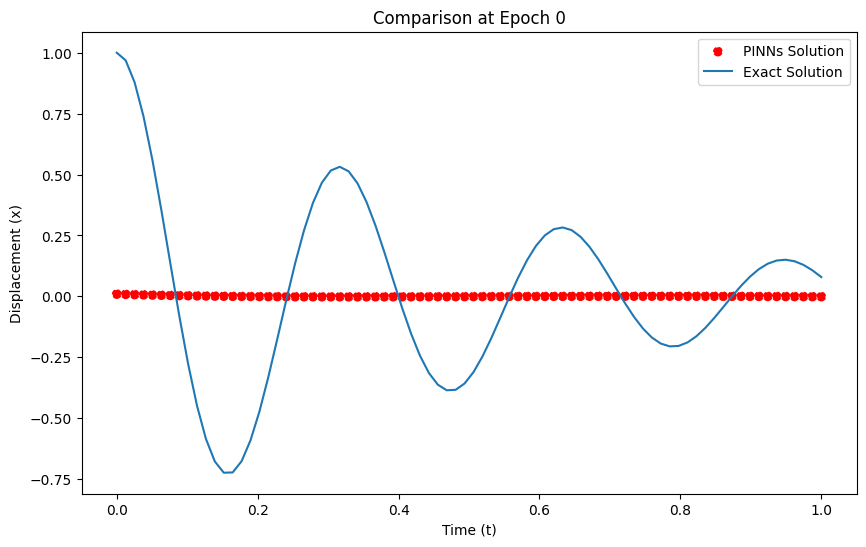

Epoch 1000, Loss: 0.12933717668056488


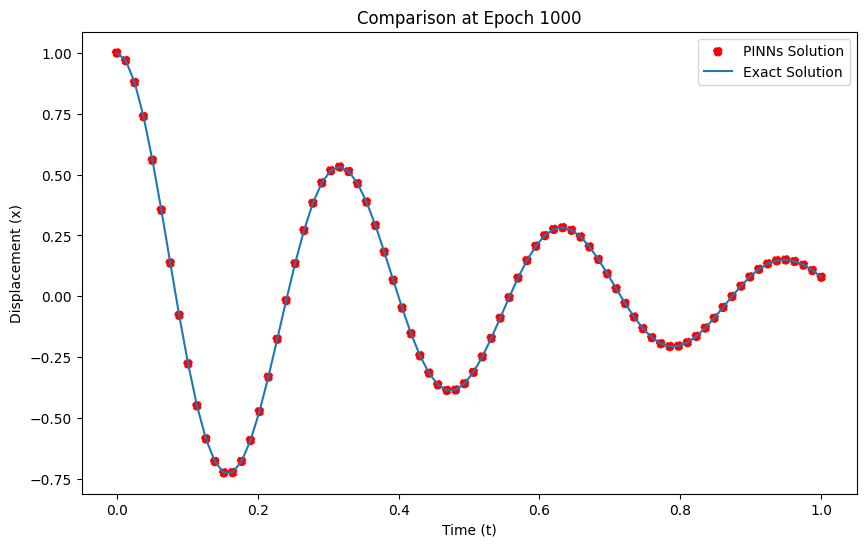

Epoch 2000, Loss: 0.12933717668056488


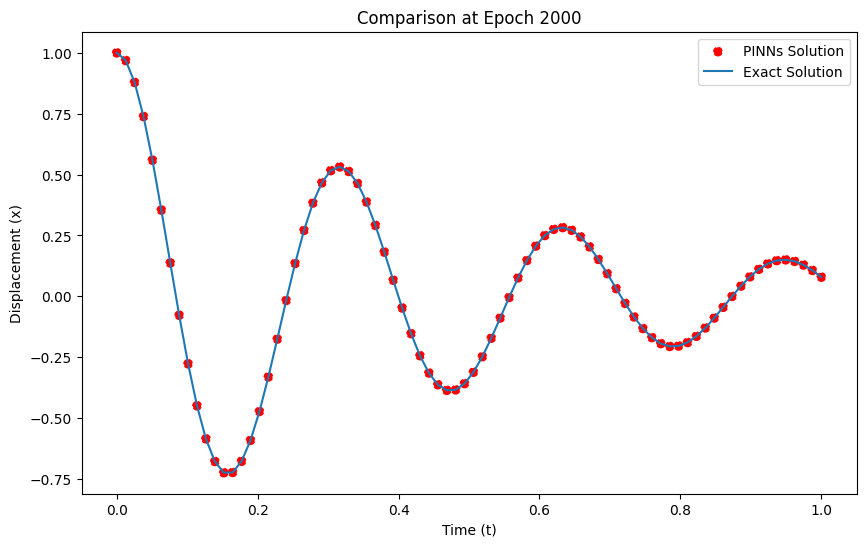

Epoch 3000, Loss: 0.12933717668056488


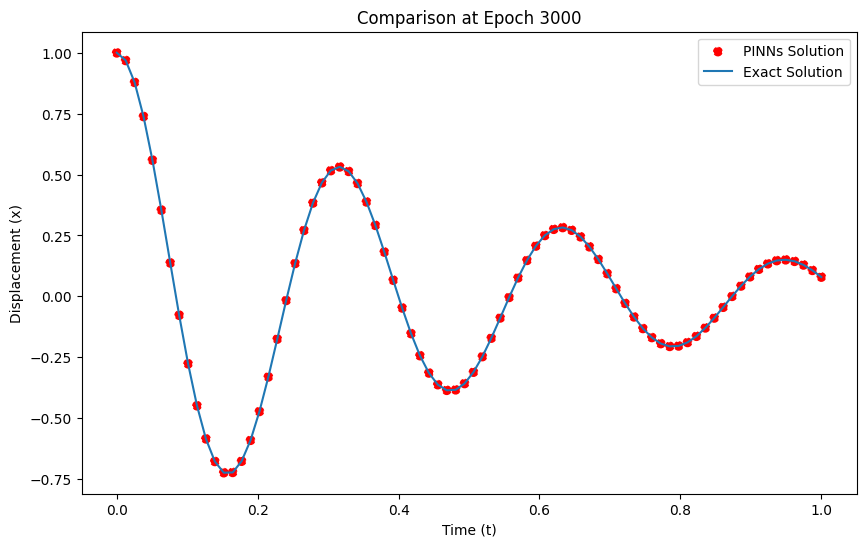

Epoch 4000, Loss: 0.12933717668056488


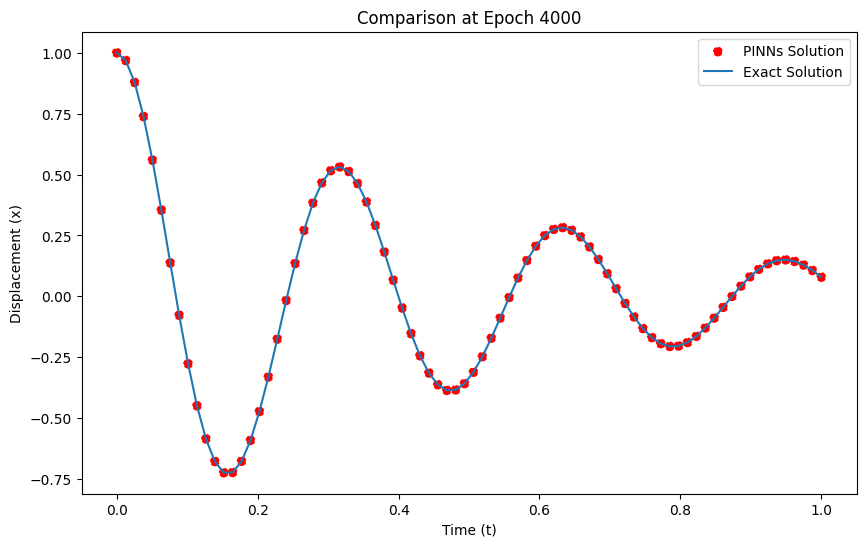

Epoch 5000, Loss: 0.12933717668056488


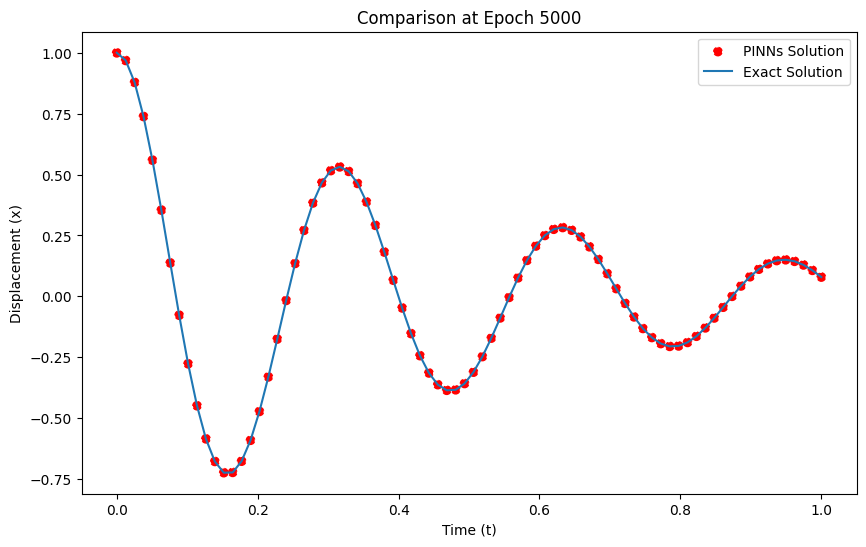

Epoch 6000, Loss: 0.12933717668056488


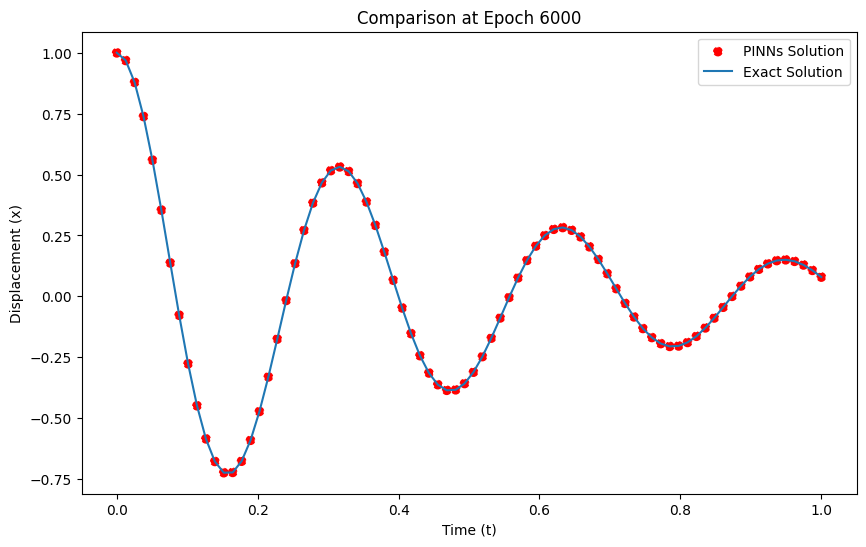

Epoch 7000, Loss: 0.12933717668056488


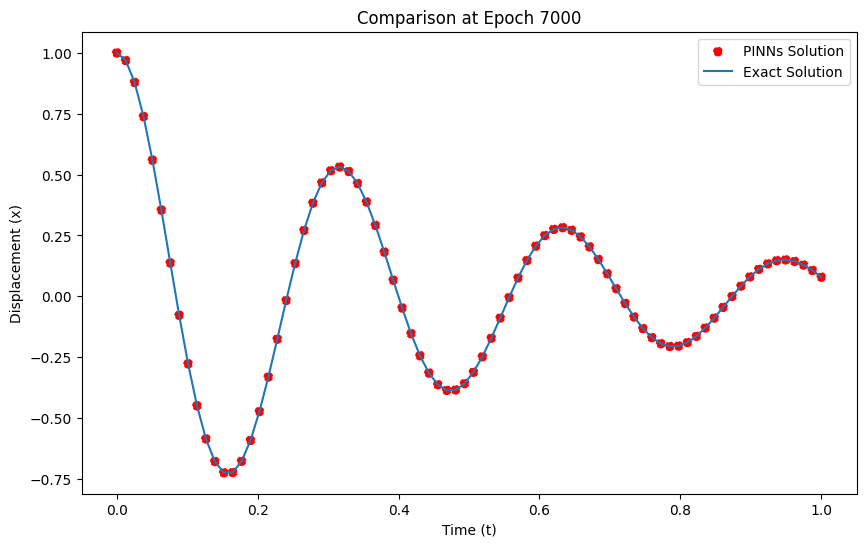

Epoch 8000, Loss: 0.12933717668056488


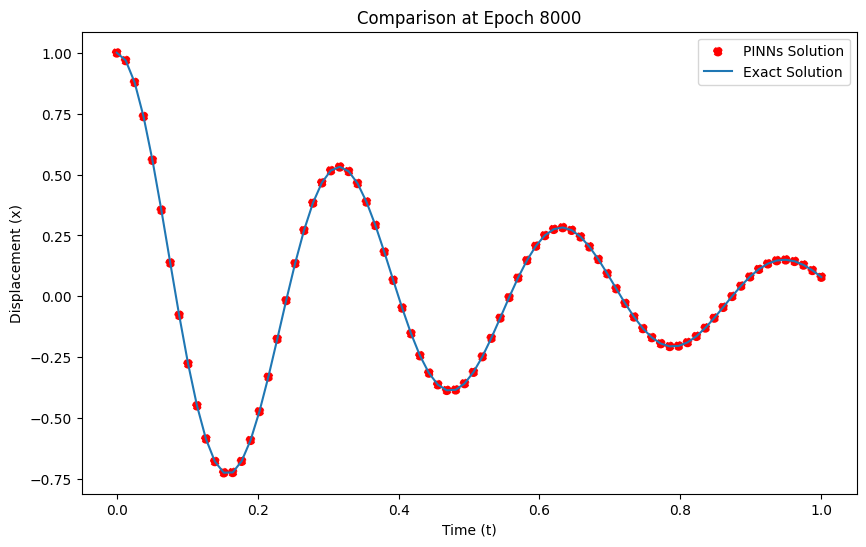

Epoch 9000, Loss: 0.12933717668056488


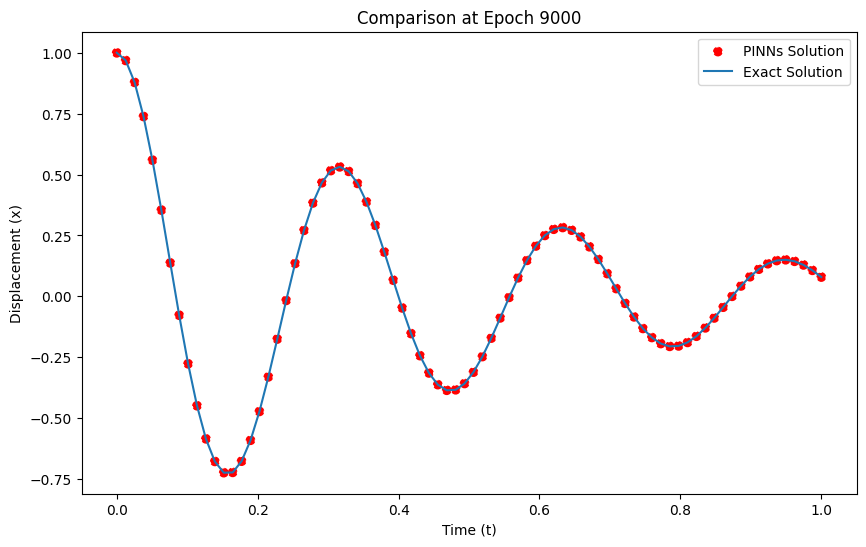

Epoch 10000, Loss: 0.12933717668056488


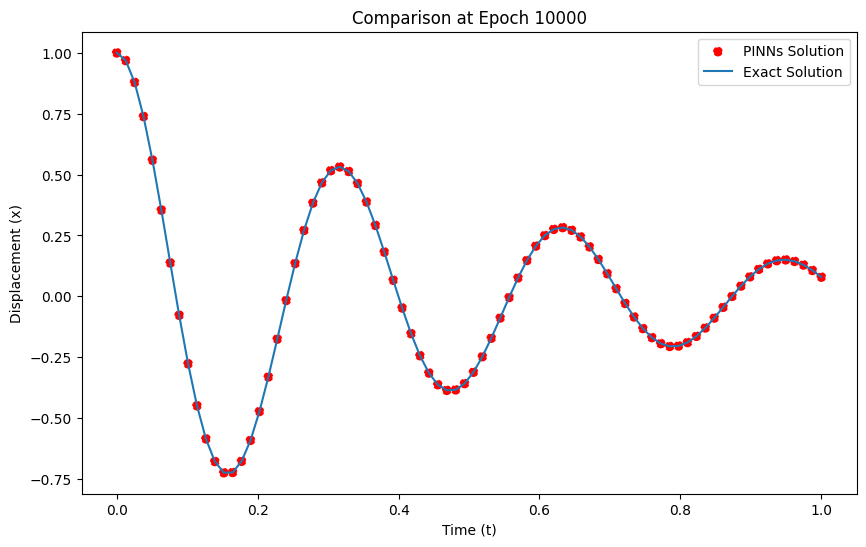

Epoch 11000, Loss: 0.12933717668056488


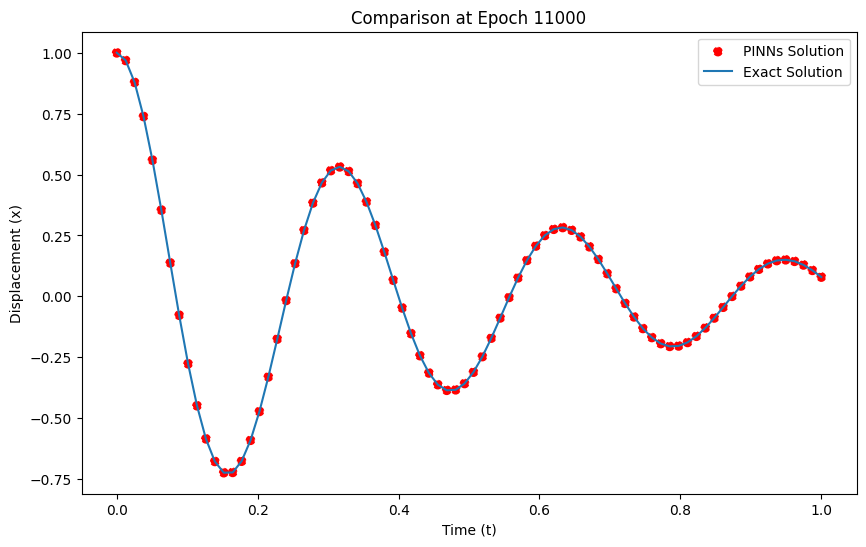

Epoch 12000, Loss: 0.12933717668056488


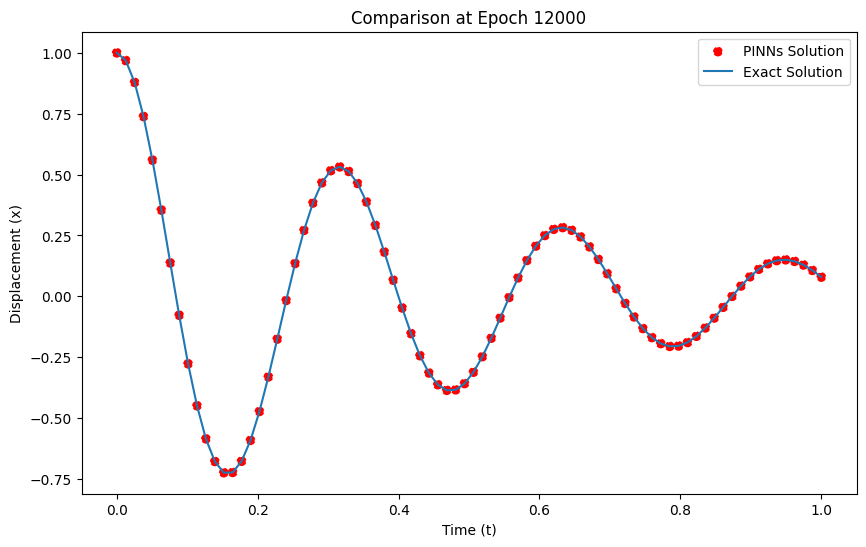

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
torch.manual_seed(42)
pinn = FCN(1,1,32,3)
optimizer = optim.LBFGS(pinn.parameters(), lr=0.1, max_iter=500)
t_train = torch.linspace(0, 1, 80, requires_grad=True).view(-1, 1)
t_boundary = torch.tensor(0.).view(-1,1)
t_boundary.requires_grad=True
k = torch.tensor(400)
mu = torch.tensor(4)
m = torch.tensor(1)
lambda1 = 1e-1
lambda2 = 1e-2
epochs = 20001
for epoch in range(epochs):
    def closure():
        optimizer.zero_grad()

        # compute boundary loss
        u = pinn(t_boundary)
        loss1 = (torch.squeeze(u) - 1)**2
        dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
        loss2 = (torch.squeeze(dudt) - 0)**2
        # compute pde loss
        u_pred = pinn(t_train)
        du_dt = torch.autograd.grad(u_pred, t_train, torch.ones_like(u_pred),create_graph=True)[0]
        d2u_dt2 = torch.autograd.grad(du_dt, t_train, torch.ones_like(du_dt),create_graph=True)[0]
        loss3 = torch.mean((m*d2u_dt2+mu*du_dt+k*u_pred)**2) #(1/M) * torch.sum((m*d2u_dt2+mu*du_dt+k*u_pred)**2)
        total_loss = loss1 + lambda1*loss2 + lambda2*loss3
        total_loss.backward()
        return total_loss
    optimizer.step(closure)

    if epoch % 1000 == 0:  # More frequent plotting
        print(f"Epoch {epoch}, Loss: {loss.item()}")  # Print loss values

        d_pinn = pinn(t_train)
        d_train = exact_solution_II(t_train,k,mu,m)

        plt.figure(figsize=(10, 6))
        plt.scatter(t_train.detach().numpy(), d_pinn.detach().numpy(), label='PINNs Solution', linestyle='dashed', color="red",alpha=1)
        plt.plot(t_train.detach().numpy(), d_train.detach().numpy(), label='Exact Solution', linestyle='solid')
        plt.legend()
        plt.xlabel('Time (t)')
        plt.ylabel('Displacement (x)')
        plt.title(f'Comparison at Epoch {epoch}')
        plt.show()


## Model Evaluation and Comparison


### Traditional Neural Network

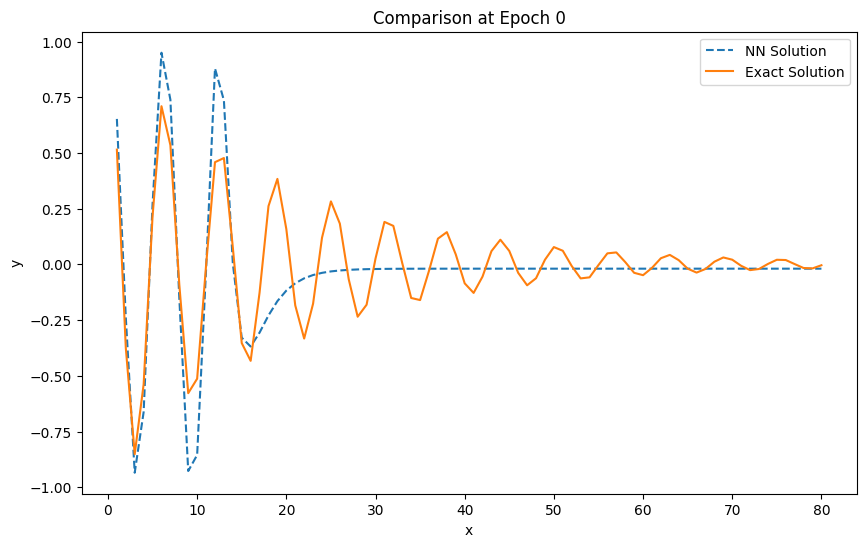

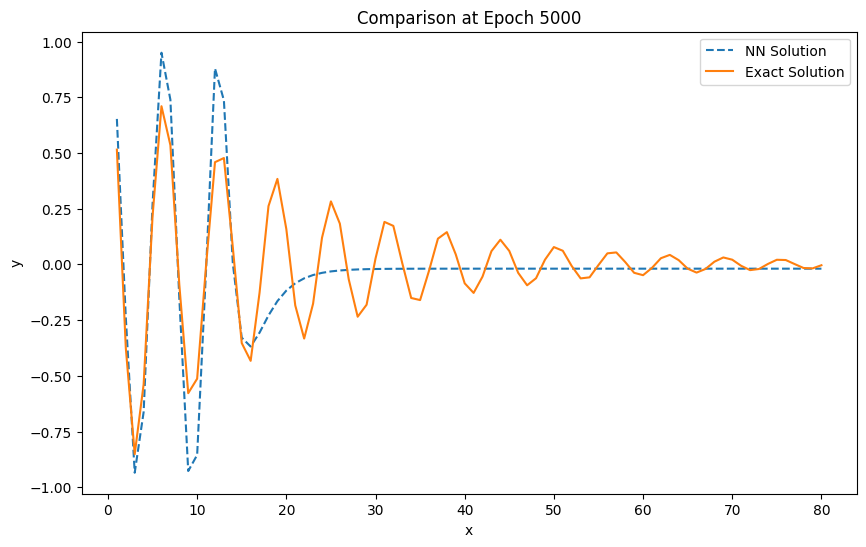

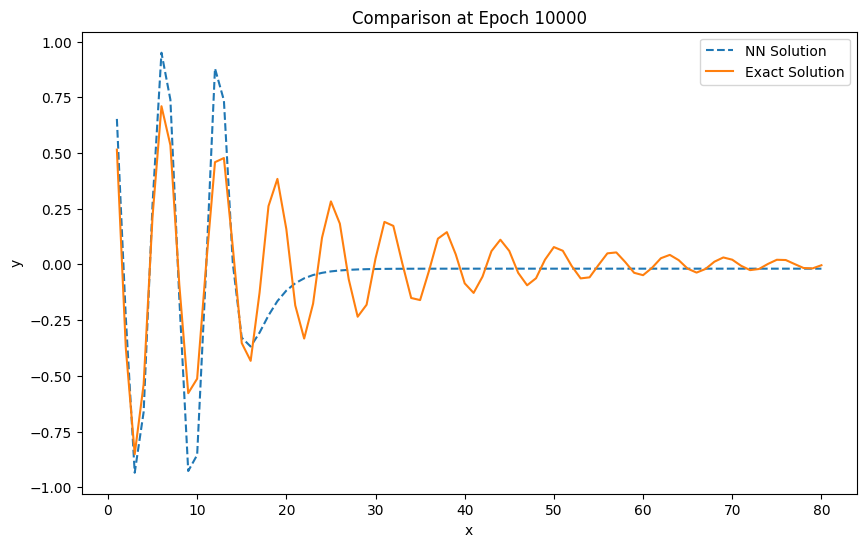

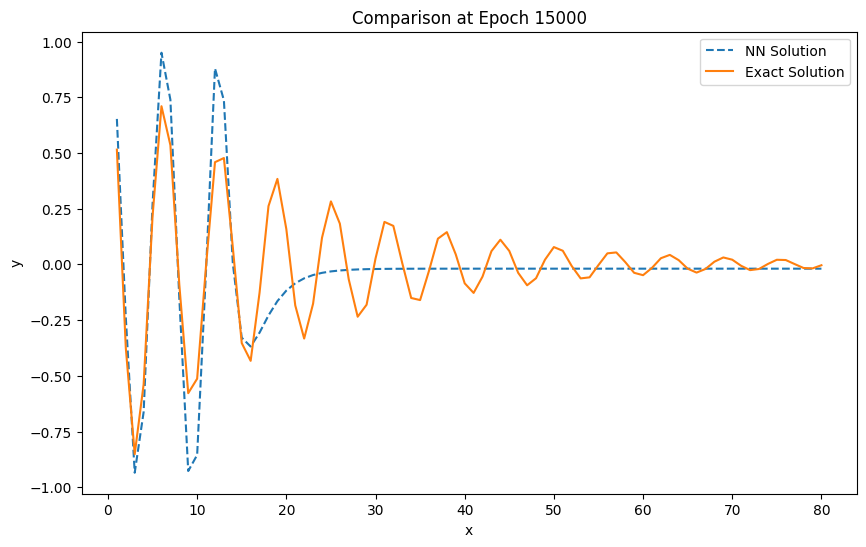

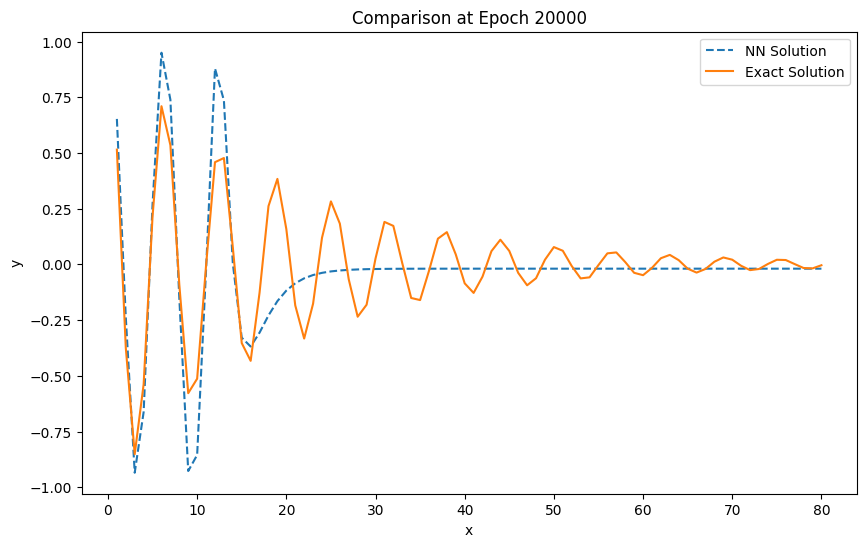

In [ ]:
# Training parameters
simpleNN_model_II = simpleNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(simpleNN_model_II.parameters(), lr=0.001)

for epoch in range(epochs):
    simpleNN_model_II.train()
    optimizer.zero_grad()

    # Forward pass
    d_pred = simpleNN_model(t_train)

    # Compute loss
    loss = criterion(d_pred, d_train)
    loss.backward()
    optimizer.step()

    if epoch % 5000 == 0:
        # Plotting the NN solution vs. exact solution
        with torch.no_grad():
            d_NN = simpleNN_model(t_train)
            d_exact = exact_solution_II(b, w0, m, t_train)

        plt.figure(figsize=(10, 6))
        plt.plot(t_train.detach().numpy(), d_NN.detach().numpy(), label='NN Solution', linestyle='dashed')
        plt.plot(t_train.detach().numpy(), d_exact.detach().numpy(), label='Exact Solution', linestyle='solid')
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'Comparison at Epoch {epoch}')
        plt.show()

### Model Evaluation: PINNs and Traditional Neural Network

In [ ]:
from sklearn.metrics import mean_squared_error

with torch.no_grad():
    t_test = torch.linspace(0, 50, 50).view(-1, 1)

    # For PINN model:
    x_pinn = model_II(t_test)
    x_exact = exact_solution_II(b, w0, m, t_test)
    mse_pinn = mean_squared_error(x_exact.detach().numpy(), x_pinn.detach().numpy())

    # For Traditional NN model:
    x_nn = simpleNN_model(t_test)
    mse_nn = mean_squared_error(x_exact.detach().numpy(), x_nn.detach().numpy())
    print(f'Mean Squared Error (Traditional NN Model): {mse_nn:.4f}')
    print(f'Mean Squared Error (PINN Model): {mse_pinn:.4f}')

Mean Squared Error (Traditional NN Model): 0.0566
Mean Squared Error (PINN Model): 0.0249


# Documentation
* In the first week:

I read the paper and struggle to understand concepts like Diffenrtial Equations.

To fill the knowledge gap, I self-studied Differential Equations, Artificial Neural Networks, Newton's Law of Cooling, and Damped Harmonic Equation using the materials listed in the Reference. I also took the Machine Learning Specialization on Coursera to gain deeper intuition into Neural Network.

* In the second week:

I decided to reproduce the growth model of simple differential equations $\frac{dy}{dx}+y=sin(x)$. The results are not really good, but it helps me understand how to apply Neural Network and PINNs to compute the solution without knowing the exact solution.

I applied PINN to a Damped Harmonic Equation. The results are not good too.

* In the third week (This week):

I documented my works. I also try to improve the model by experimenting with different loss function, architect, and learning rate.


# Reference

1. Farea A., Yli-Harja O., and Emmert-Streib F., Understanding Physics-Informed Neural Networks: Techniques, applications, trends, and challenges. AI, 5, (2024) 3, 1534-1557. https://doi.org/10.3390/ai5030074

2. Farea A., ODE-PINN. GitHub. Available at: https://github.com/AmerFarea/ODE-PINN

3. Beltoforion. Harmonic Oscillator. Beltoforion. Available at: https://beltoforion.de/en/harmonic_oscillator/

4. Moseley B., So, what is a Physics-Informed Neural Network? Ben Moseley. Available at: https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/

5. 3Blue1Brown, Differential Equation Series. Available at: https://www.youtube.com/user/3blue1brown
